In [2]:
library(foreign)
library(purrr)
library(data.table)
library(dplyr)
library(ggplot2)  # hadley/ggplot2
library(scales)
library(ggalt)
library(hrbrmisc) # hrbrmstr/hrbrmisc
library(readxl)
library(stringi)
library(viridis)
library(rvest)
library(tidyr)

In [3]:
setwd("data")

In [4]:
load("accidents.rda")

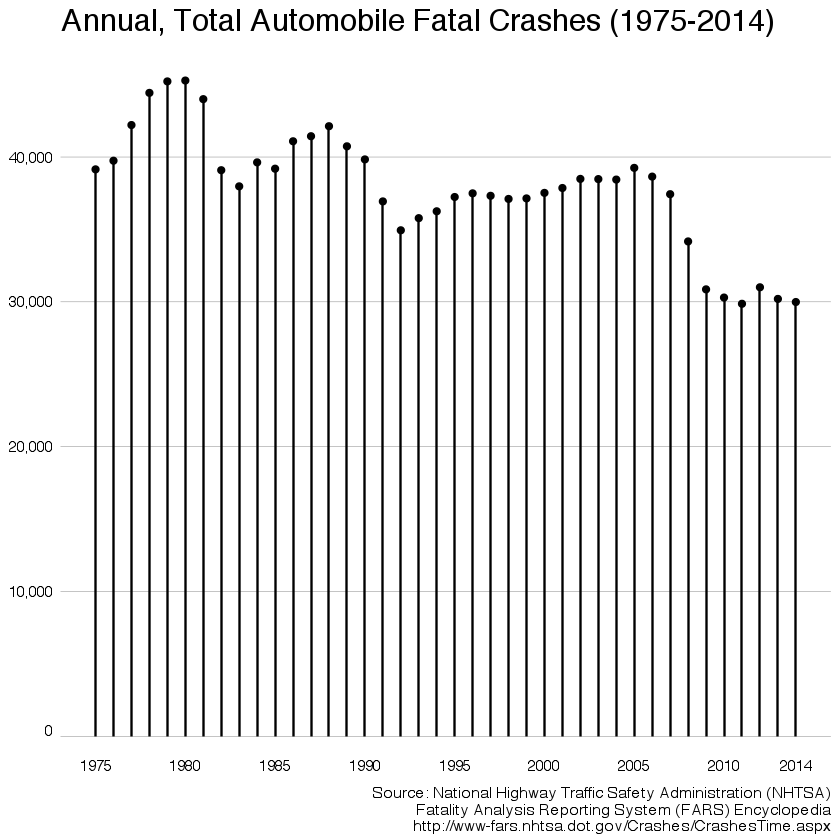

In [5]:
gg <- ggplot(count(filter(accidents, !is.na(fatals) & fatals>0), year), aes(year, n))
gg <- gg + geom_lollipop()
gg <- gg + scale_x_continuous(name=NULL, breaks=c(1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014))
gg <- gg + scale_y_continuous(name=NULL, labels=comma)
gg <- gg + expand_limits(y=0)
gg <- gg + labs(title="Annual, Total Automobile Fatal Crashes (1975-2014)",
                caption="Source: National Highway Traffic Safety Administration (NHTSA)\nFatality Analysis Reporting System (FARS) Encyclopedia\nhttp://www-fars.nhtsa.dot.gov/Crashes/CrashesTime.aspx")
gg <- gg + theme_hrbrmstr_an(grid="Y")
gg <- gg + theme(axis.text.x=element_text(margin=margin(t=-20)))
gg <- gg + theme(axis.text.y=element_text(vjust=c(0, rep(0.5, 5))))
gg

In [6]:
gsa_url <- "http://www.gsa.gov/portal/getMediaData?mediaId=214171"
gsa_fil <- "gsa.xlsx"

if (!file.exists(gsa_fil)) download.file(gsa_url, gsa_fil)

gsa <- read_excel(gsa_fil, skip=1)

distinct(gsa, `State Name`, `State Abbreviation`, `State Code`) %>%
  select(name=2, abbrev=3, code=4) %>%
  mutate(name=stri_trans_totitle(name),
         code=as.integer(code)) -> gsa_states

In [7]:
tbl_df(accidents) %>%
  filter(!is.na(fatals) & fatals>0) %>%
  count(year, state) %>%
  mutate(state=as.integer(state)) %>%
  left_join(gsa_states, by=c(state="code")) %>%
  ungroup() %>%
  mutate(decade=(year %/% 10) * 10) -> by_state

In [8]:
c2n <- function(x) { as.numeric(gsub(",", "", trimws(x))) }

state_pop_url <- "https://en.wikipedia.org/wiki/List_of_U.S._states_by_historical_population"
state_pop_fil <- "wp_uspop.html"
if (!file.exists(state_pop_fil)) download.file(state_pop_url, state_pop_fil)

pg <- read_html(state_pop_fil)
state_pop <- html_table(html_nodes(pg, xpath=".//h2[contains(., 'Table 3')]/following::table[1]"))[[1]]

select(state_pop, name=Name, everything(), -`1960`) %>%
  mutate_each(funs=funs(c2n), -name) %>%
  gather(decade, population, -name) %>%
    mutate(decade=as.numeric(decade)) -> state_pop

left_join(by_state, state_pop, by=c("name", "decade")) %>%
  mutate(per_capita=(n/population)*100000) -> by_state

state_ord <- arrange(count(by_state, name, wt=per_capita), desc(n))$name

mutate(by_state, name=factor(name, levels=state_ord)) %>%
  filter(name != "District Of Columbia") -> by_state

Warning message:
In grid.Call.graphics(L_raster, x$raster, x$x, x$y, x$width, x$height, : raster rendering is not implemented for this device

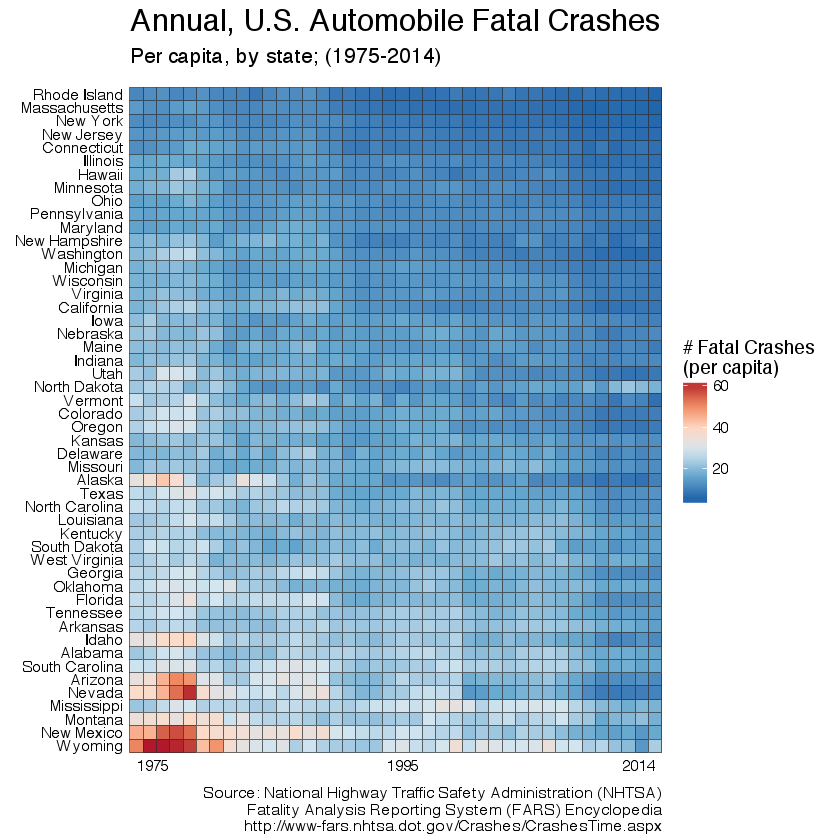

In [9]:
gg <- ggplot(by_state, aes(factor(year), name, fill=per_capita))
gg <- gg + geom_tile(color="#2b2b2b", size=0.15)
gg <- gg + scale_x_discrete(name=NULL, expand=c(0,0), breaks=c(1975, 1995, 2014))
gg <- gg + scale_y_discrete(name=NULL, expand=c(0,0))
gg <- gg + scale_fill_distiller(name="# Fatal Crashes\n(per capita)", label=comma, palette="RdBu", direction=-1)
gg <- gg + coord_equal()
gg <- gg + labs(title="Annual, U.S. Automobile Fatal Crashes",
                subtitle="Per capita, by state; (1975-2014)",
                caption="Source: National Highway Traffic Safety Administration (NHTSA)\nFatality Analysis Reporting System (FARS) Encyclopedia\nhttp://www-fars.nhtsa.dot.gov/Crashes/CrashesTime.aspx")
gg <- gg + theme_hrbrmstr_an(grid="Y")
gg <- gg + theme(axis.text.x=element_text(hjust=c(0, 0.5, 1)))
gg